# Data X checks

### Apr 19, 2021

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
# sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/SourceSearch")
# import deDisperse_util as util
import matplotlib.colors as colors

my_path_plots = os.path.abspath("./plots/")
import re


Welcome to JupyROOT 6.18/04


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


# Get data

In [3]:
file_list=[]#Define an empty list
for filename in os.listdir("/fs/project/PAS0654/ARA_DATA/A23/sim_SourceSearch/A2/Joined"):#Loop over desired directory
    if filename.endswith(".root"): #extension, .root in this case
        file_list.append(os.path.join("/fs/project/PAS0654/ARA_DATA/A23/sim_SourceSearch/A2/Joined", str(filename))) #add file name to the list
        

In [5]:
chain = TChain("OutputTree_recoRadius_19") #Define chain and tree that needs to be read. "RecoVals" in this case.
for line in file_list:
    chain.AddFile(line)

In [6]:
phi = []
theta = []
phi_h = []
theta_h = []
viewAnglAvg = []
corr_value = []
weights = []
for entry in chain:
#     if(entry.peakCorr_single[0]<0.01): continue
#     if(entry.peakPhi_single[0]<0):
#         phi.append(entry.peakPhi_single[0]+180) #extract variables of interest
#     else:
    phi.append(entry.peakPhi_single[0]) 
#     phi_h.append(entry.peakPhi_single[1]) 
    theta.append(entry.peakTheta_single[0])
#     theta_h.append(entry.peakTheta_single[1])
#     viewAnglAvg.append(entry.viewAngleAvg[0])
    corr_value.append(entry.peakCorr_single[0])
    weights.append(entry.weight)

# Look at distributions

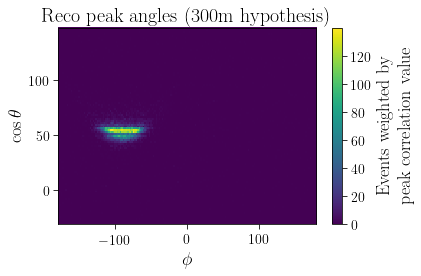

In [35]:
plt.hist2d(phi,np.array(theta)+58, bins=[180,100], weights=weights);
plt.colorbar(label="Events weighted by \n peak correlation value")
# plt.scatter(np.degrees(1.571)-180,180-np.degrees(2.32)-58, color="red")
plt.xlabel("$\phi$")
plt.ylabel("$\cos\\theta$")
plt.title("Reco peak angles (300m hypothesis)")
plt.tight_layout()

In [49]:
from scipy.stats import gaussian_kde
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm

x=phi
y=np.cos(np.radians(np.array(theta)+58))
# y = theta
xy = np.vstack([x,y])
kernel = gaussian_kde(xy, bw_method='silverman', weights=weights)

xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)

In [50]:
X, Y = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)

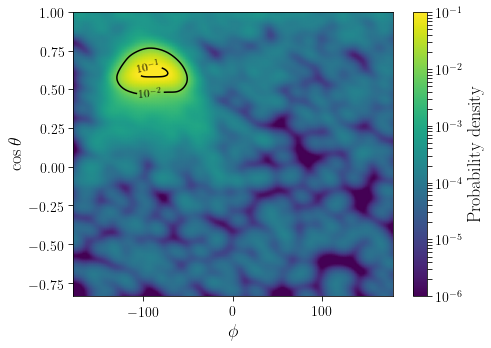

In [51]:
plt.figure(figsize=(7,5))
from matplotlib import ticker, cm

levels = [1e-2,1e-1]

contours = plt.contour(X, Y, Z,levels,locator=plt.LogLocator(),colors="black")
# cmap = plt.contourf(X, Y, Z,200)
fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()
plt.clabel(contours, contours.levels,color="black", fmt=fmt, inline=True)
cmap=plt.pcolormesh(X, Y, Z,shading='gouraud', norm=colors.LogNorm(vmin=1E-6, vmax=1e-1))

# cmap = plt.get_cmap('PiYG')
plt.colorbar(cmap,label='Probability density',norm=LogNorm())
# plt.title("Hpol")
plt.xlabel("$\phi$")
plt.ylabel("$\cos\\theta$")
plt.tight_layout()
# plt.savefig("KDE_CenA_recoPeak_300m_hpol.pdf", dpi=300)

## Make list of files

In [151]:
regex = re.compile(r'\d+')
folderExport = "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/ARA_SourceSearch/OSC_scripts/step6-save_vals_for_cuts/runsInConfig"
runs = []
for config in range(1,6):
    configRuns = []
    sourceFolder = "/fs/project/PAS0654/ARA_DATA/A23/10pctCalibBugFix/Joined/A2/by_config/c%i"%config
    file_list=[]#Define an empty list
    for filename in os.listdir(sourceFolder):#Loop over desired directory
        if filename.endswith(".root"): #extension, .root in this case
            file_list.append(os.path.join(sourceFolder, str(filename))) #add file name to the list
            run = regex.findall(filename)[1]
            configRuns.append(run)
    configRuns = sorted(configRuns)    
    df = pd.DataFrame(np.array(configRuns), columns=['run'])
    df.to_csv(os.path.join(folderExport, "runs_c%i.csv"%config), index=False)

In [153]:
a = pd.read_csv(folderExport+"/runs_c2.csv")

In [161]:
for run in a.run:
    print(run)

1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1463
1464
1465
1466
1467
1468
1469
1470
1471
1473
1474
1475
1476
1478
1479
1480
1481
1483
1484
1485
1486
1488
1489
1490
1491
1493
1494
1495
1496
1498
1499
1500
1501
1503
1504
1505
1506
1508
1509
1510
1511
1513
1514
1515
1516
1518
1519
1520
1521
1523
1524
1525
1526
1528
1529
1530
1531
1533
1534
1535
1536
1538
1539
1540
1541
1543
1544
1545
1546
1547
1548
1550
1551
1552
1553
1555
1556
1557
1558
1560
1561
1562
1563
1565
1566
1567
1568
1570
1571
1572
1573
1575
1576
1577
1578
1580
1581
1582
1583
1585
1586
1587
1588
1590
1591
1592
1593
1595
1596
1597
1598
1600
1601
1602
1603
1605
1606
1607
1608
1609
1611
1612
1613
1614
1616
1617
1618
1619
1621
1622
1623
1624
1626
1627
1628
1629
1631
1632
1633
1634
1637
1639
1640
1641
1642
1645
1646
1647
1652
1653
1654
1655
1657
1658
1659
1660
1662
1663
1664
1665
1667
1668
1669
1670
1672
1673
1674
1675
1677
1678
1679
1680
1682
1683
1684
1685
1687
1688
1689
1690
1692
1693
1694
1695
1697
1698
1699
1700


In [159]:
b

'run'